## Exploratory analysis
In this Jupyter Notebook we will perform the basic steps of exploratory analysis for a better understanding of the data we will work with. Content:
* Environment set up
* Analysis of synthetic detached data
* Analysis of synthetic over-contact data
* Analysis of observed detached data
* Analysis of observed over-contact data

## 1. Environment set-up
* Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from random import randint


* Defining functions for noise generation, set-up of random sigma value generator, function to plot synthetic light curves, function to plot observed light curves.
* Inputs:
    * for function generate_observation_sigma(space_obs_frac=0.5) - space_obs_frac=0.5
    * for function stochastic_noise_generator(curve) - vector of light curve
    * for function synthetic_curves_plot(n, data, data_noise) - random *n*, array of light curve vector of synthetic data without noise, array of light curve vector of synthetic data with noise
    * for function observed_curves_plot(name, obs) - name of light curve, dataset of observed binary systems

In [2]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

def synthetic_curves_plot(n, data, data_noise):
    plt.plot(data[n], color="yellow", linewidth=10)
    plt.plot(data_noise[n*3], color="red", linewidth=0.5)
    plt.plot(data_noise[n*3+1], color="blue", linewidth=0.5)
    plt.plot(data_noise[n*3+2], color="green", linewidth=0.5)
    plt.title("The original curve and its noise curves")
    plt.show()

def observed_curves_plot(name, obs):
    name_c=obs[obs["name"]==name]["name"].count()
    curves=obs[obs["name"]==name][["filter", "curve"]].reset_index()
    for i in range(name_c):
        plt.plot(literal_eval(curves.curve[i]), label=curves["filter"][i])
    plt.legend(title="filter")
    plt.title(name)
    plt.show()

## 2. Analysis of synthetic detached data

* Data loading

In [3]:
data_det = pd.read_pickle("detached_all_parameters.pkl").reset_index()

* Details about number of records, number of columns and column names

In [4]:
print("Number of records: ", data_det.shape[0])
print("Number of attributes: ", data_det.shape[1])
print("Attributes: ", list(data_det.columns))

Number of records:  1300000
Number of attributes:  16
Attributes:  ['index', 'id', 'curve', 'primary__t_eff', 'secondary__t_eff', 'inclination', 'mass_ratio', 'primary__surface_potential', 'secondary__surface_potential', 't1_t2', 'filter', 'critical_surface_potential', 'primary__equivalent_radius', 'secondary__equivalent_radius', 'primary__filling_factor', 'secondary__filling_factor']


* Details about unique filters and distribution of data for each of them

In [5]:
print("Unique filters:", data_det["filter"].unique())
print("Distribution of records in each type of filter: \n", data_det["filter"].value_counts())

Unique filters: ['Bessell_U' 'Bessell_B' 'Bessell_V' 'Bessell_R' 'Bessell_I' 'SLOAN_u'
 'SLOAN_g' 'SLOAN_r' 'SLOAN_i' 'SLOAN_z' 'Kepler' 'GaiaDR2' 'TESS']
Distribution of records in each type of filter: 
 SLOAN_u      100000
GaiaDR2      100000
SLOAN_z      100000
TESS         100000
Bessell_B    100000
Bessell_V    100000
SLOAN_i      100000
Bessell_U    100000
SLOAN_g      100000
Bessell_R    100000
SLOAN_r      100000
Bessell_I    100000
Kepler       100000
Name: filter, dtype: int64


* Basic statistics about numeric columns

In [6]:
data_det_copy = data_det.copy()
data_det_copy = data_det_copy.drop(columns=['index', 'id', 'curve', 'filter'])
print("Description of numeric attributes: \n ", data_det_copy.describe())

Description of numeric attributes: 
         primary__t_eff  secondary__t_eff   inclination    mass_ratio  \
count    1.300000e+06      1.300000e+06  1.300000e+06  1.300000e+06   
mean     2.243716e+04      1.013212e+04  1.375220e+00  1.752090e+00   
std      1.165838e+04      6.355424e+03  1.632513e-01  2.142423e+00   
min      4.000000e+03      4.000000e+03  7.377260e-01  1.000000e-01   
25%      1.200000e+04      6.000000e+03  1.267385e+00  6.000000e-01   
50%      2.000000e+04      8.000000e+03  1.413717e+00  1.000000e+00   
75%      3.000000e+04      1.200000e+04  1.509858e+00  2.000000e+00   
max      4.500000e+04      4.500000e+04  1.570796e+00  1.000000e+01   

       primary__surface_potential  secondary__surface_potential         t1_t2  \
count                1.300000e+06                  1.300000e+06  1.300000e+06   
mean                 1.803112e+01                  1.672032e+01  2.652065e+00   
std                  2.757523e+01                  4.359045e+01  1.801657e+00  

* Correlation matrix
    * We selected only *inclination, mass ratio, potentials, temperature ratio* and *radii* to calculate correlation matrix, as those parameters are the most important for us, as we can use them to plot light curves.

In [7]:
corr_df = data_det_copy[["inclination", "mass_ratio", "primary__surface_potential", "secondary__surface_potential", "t1_t2", 'primary__equivalent_radius', 'secondary__equivalent_radius']].corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1_t2,primary__equivalent_radius,secondary__equivalent_radius
inclination,1.000000,-0.017152,0.259710,0.183215,0.003829,-0.385719,-0.389623
mass_ratio,-0.017152,1.000000,0.246351,0.292166,-0.019585,-0.295549,0.338506
primary__surface_potential,0.259710,0.246351,1.000000,0.207168,0.049165,-0.599601,-0.081900
secondary__surface_potential,0.183215,0.292166,0.207168,1.000000,-0.055904,-0.189841,-0.287798
t1_t2,0.003829,-0.019585,0.049165,-0.055904,1.000000,-0.059394,0.055464
primary__equivalent_radius,-0.385719,-0.295549,-0.599601,-0.189841,-0.059394,1.000000,-0.013233
secondary__equivalent_radius,-0.389623,0.338506,-0.081900,-0.287798,0.055464,-0.013233,1.000000


* We selected random sample of 10 light curves, added noise to them and saved them into *X_det_n*

In [8]:
data_det_sample = data_det.sample(n=10)

X_det=[]
for row in data_det_sample["curve"]:
    X_det.append(row)
X_det=np.array(X_det)

X_det_n=[]
for i in range(len(data_det_sample)):
    for j in range(3):
        curve=stochastic_noise_generator(X_det[i])
        X_det_n.append(curve[0])

* Light curves saved in *X_det_n* variable are used for plotting - 1. plot
* We added random noise to one of them and plotted light curve with noise - 2. plot

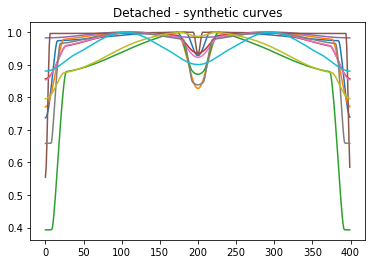

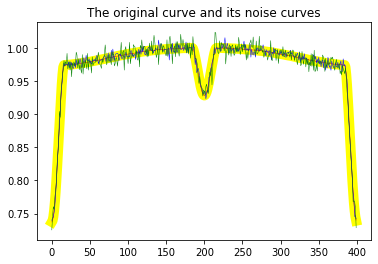

In [9]:
for i in range(len(X_det)):
    plt.plot(X_det[i])
plt.title("Detached - synthetic curves")
plt.show()

synthetic_curves_plot(randint(0, len(X_det)), X_det, X_det_n)

## 3. Analysis of synthetic overcontact data

* Data loading

In [10]:
data_over = pd.read_pickle("overcontact_all_parameters.pkl").reset_index()

* Details about number of records, number of columns and column names

In [11]:
print("Number of records: ", data_over.shape[0])
print("Number of attributes: ", data_over.shape[1])
print("Attributes: ", list(data_over.columns))

Number of records:  1212796
Number of attributes:  16
Attributes:  ['index', 'id', 'curve', 'primary__t_eff', 'secondary__t_eff', 'inclination', 'mass_ratio', 'primary__surface_potential', 'secondary__surface_potential', 't1/t2', 'filter', 'critical_surface_potential', 'primary__equivalent_radius', 'secondary__equivalent_radius', 'primary__filling_factor', 'secondary__filling_factor']


* Details about unique filters and distribution of data for each of them

In [12]:
print("Unique filters:", data_over["filter"].unique())
print("Distribution of records in each type of filter: \n", data_over["filter"].value_counts())

Unique filters: ['Bessell_U' 'Bessell_B' 'Bessell_V' 'Bessell_R' 'Bessell_I' 'SLOAN_u'
 'SLOAN_g' 'SLOAN_r' 'SLOAN_i' 'SLOAN_z' 'Kepler' 'GaiaDR2' 'TESS']
Distribution of records in each type of filter: 
 SLOAN_u      93292
GaiaDR2      93292
SLOAN_z      93292
TESS         93292
Bessell_B    93292
Bessell_V    93292
SLOAN_i      93292
Bessell_U    93292
SLOAN_g      93292
Bessell_R    93292
SLOAN_r      93292
Bessell_I    93292
Kepler       93292
Name: filter, dtype: int64


* Basic statistics about numeric columns

In [13]:
data_over_copy = data_over.copy()
data_over_copy = data_over_copy.drop(columns=['index', 'id', 'curve', 'filter'])
print("Description of numeric attributes: \n ", data_over_copy.describe())

Description of numeric attributes: 
         primary__t_eff  secondary__t_eff   inclination    mass_ratio  \
count    1.212796e+06      1.212796e+06  1.212796e+06  1.212796e+06   
mean     6.537040e+03      6.246543e+03  1.222625e+00  1.420822e+00   
std      9.691032e+02      9.725411e+02  2.181624e-01  1.389326e+00   
min      4.250000e+03      4.250000e+03  4.949341e-01  1.000000e-01   
25%      5.750000e+03      5.500000e+03  1.048325e+00  9.000000e-01   
50%      6.500000e+03      6.250000e+03  1.230496e+00  1.000000e+00   
75%      7.250000e+03      7.000000e+03  1.409921e+00  1.428571e+00   
max      8.000000e+03      8.000000e+03  1.570796e+00  1.000000e+01   

       primary__surface_potential  secondary__surface_potential         t1/t2  \
count                1.212796e+06                  1.212796e+06  1.212796e+06   
mean                 3.985917e+00                  3.985917e+00  1.048225e+00   
std                  1.840244e+00                  1.840244e+00  3.288309e-02  

* Correlation matrix
    * We selected only *inclination, mass ratio, potentials, temperature ratio* and *radii* to calculate correlation matrix, as those parameters are the most important for us, as we can use them to plot light curves.

In [14]:
corr_df = data_over_copy[["inclination", "mass_ratio", "primary__surface_potential", "secondary__surface_potential", "t1/t2", 'primary__equivalent_radius', 'secondary__equivalent_radius']].corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1/t2,primary__equivalent_radius,secondary__equivalent_radius
inclination,1.000000,-0.033122,-0.017862,-0.017862,0.008147,-0.068383,-0.081698
mass_ratio,-0.033122,1.000000,0.994906,0.994906,-0.139198,-0.786212,0.628690
primary__surface_potential,-0.017862,0.994906,1.000000,1.000000,-0.147475,-0.842158,0.619082
secondary__surface_potential,-0.017862,0.994906,1.000000,1.000000,-0.147475,-0.842158,0.619082
t1/t2,0.008147,-0.139198,-0.147475,-0.147475,1.000000,0.174635,-0.197944
primary__equivalent_radius,-0.068383,-0.786212,-0.842158,-0.842158,0.174635,1.000000,-0.528705
secondary__equivalent_radius,-0.081698,0.628690,0.619082,0.619082,-0.197944,-0.528705,1.000000


* We selected random sample of 10 light curves, added noise to them and saved them into *X_over_n*

In [15]:
data_over_sample = data_over.sample(n=10)

X_over=[]
for row in data_over_sample["curve"]:
    X_over.append(row)
X_over=np.array(X_over)

X_over_n=[]
for i in range(len(data_over_sample)):
    for j in range(3):
        curve=stochastic_noise_generator(X_over[i])
        X_over_n.append(curve[0])

* Light curves saved in *X_over_n* variable are used for plotting - 1. plot
* We added random noise to one of them and plotted light curve with noise - 2. plot

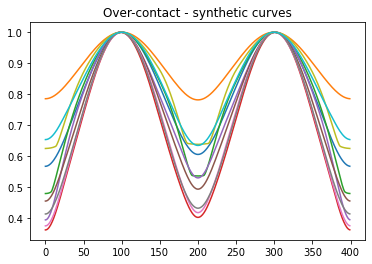

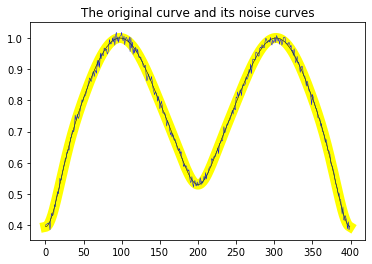

In [16]:
for i in range(len(X_over)):
    plt.plot(X_over[i])
plt.title("Over-contact - synthetic curves")
plt.show()

synthetic_curves_plot(randint(0, len(X_over)), X_over, X_over_n)

## 4. Analysis of observed detached data

* Data loading

In [17]:
obs_det = pd.read_csv("observed/observed_det.csv")

* Details about number of records, number of columns and column names

In [18]:
print("Number of records: ", obs_det.shape[0])
print("Number of attributes: ", obs_det.shape[1])
print("Attributes: ", list(obs_det.columns))

Number of records:  25
Number of attributes:  17
Attributes:  ['Unnamed: 0', 'q', 'inc', 'omega1', 'omega2', 'T1', 'T2', 'P', 'Type', 'Spot', 'Ref', 'name', 'filter', 'curve', 't1_t2', 'primary__equivalent_radius', 'secondary__equivalent_radius']


* Details about unique filters and distribution of data for each of them

In [19]:
print("Unique filters:", obs_det["filter"].unique())
print("Distribution of records in each type of filter: \n", obs_det["filter"].value_counts())

Unique filters: ['V' 'I' 'R' 'B']
Distribution of records in each type of filter: 
 V    9
B    7
R    7
I    2
Name: filter, dtype: int64


* Basic statistics about numeric columns

In [20]:
obs_det_copy = obs_det.copy()
obs_det_copy = obs_det_copy.drop(columns=['Unnamed: 0', 'Type', 'Spot', 'Ref', 'name', 'filter', 'curve',])
print("Description of numeric attributes: \n ", obs_det_copy.describe())

Description of numeric attributes: 
                 q        inc     omega1     omega2           T1           T2  \
count  25.000000  25.000000  25.000000  25.000000    25.000000    25.000000   
mean    0.485440  83.460000   4.397080   3.445040  7442.400000  5143.160000   
std     0.303068   4.421884   1.873939   2.017025  1108.257942  1325.770709   
min     0.135000  76.300000   2.540000   2.062000  5900.000000  3450.000000   
25%     0.279000  78.300000   2.859000   2.420000  5940.000000  4260.000000   
50%     0.366000  84.700000   4.200000   2.608000  7800.000000  5057.000000   
75%     0.484000  87.700000   4.329000   2.850000  8000.000000  5707.000000   
max     1.000000  88.700000   8.550000   8.550000  9400.000000  7994.000000   

               P      t1_t2  primary__equivalent_radius  \
count  25.000000  25.000000                   25.000000   
mean    1.729364   1.516795                    0.303513   
std     1.637097   0.346533                    0.108062   
min     0.4069

* Correlation matrix
    * We selected only *inclination, mass ratio, potentials, temperature ratio* and *radii* to calculate correlation matrix, as those parameters are the most important for us, as we can use them to plot light curves.

In [21]:
corr_df = obs_det_copy[['q', 'inc', 'omega1', 'omega2', 't1_t2', 'primary__equivalent_radius', 'secondary__equivalent_radius']].corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,q,inc,omega1,omega2,t1_t2,primary__equivalent_radius,secondary__equivalent_radius
q,1.000000,0.294429,0.519024,0.840565,-0.815947,-0.350560,-0.314474
inc,0.294429,1.000000,-0.235869,0.198903,-0.379248,0.474847,-0.021933
omega1,0.519024,-0.235869,1.000000,0.792635,-0.369699,-0.923840,-0.865623
omega2,0.840565,0.198903,0.792635,1.000000,-0.711391,-0.556842,-0.747510
t1_t2,-0.815947,-0.379248,-0.369699,-0.711391,1.000000,0.103855,0.354392
primary__equivalent_radius,-0.350560,0.474847,-0.923840,-0.556842,0.103855,1.000000,0.671091
secondary__equivalent_radius,-0.314474,-0.021933,-0.865623,-0.747510,0.354392,0.671091,1.000000


* In the next plot we can see all observed detached light curve. To be able to read array of light curve we need to use *literal_eval()* function

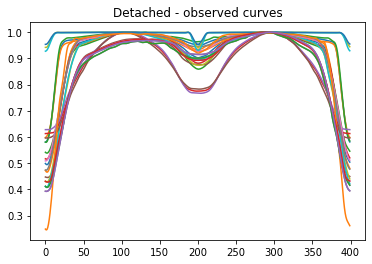

In [22]:
for i in range(len(obs_det)):
    plt.plot(literal_eval(obs_det.curve[i]))
plt.title("Detached - observed curves")
plt.show()

* In the next plot we can see light curve of ATPeg binary star plotted for each filter of V, I, R, B using our function *observed_curves_plot()*

Unique names: ['ATPeg' 'BUVul' 'FROri' 'IOUMA' 'LLCom' 'V548Cyg' 'v773cas' 'Y Cam'
 'WYHya']


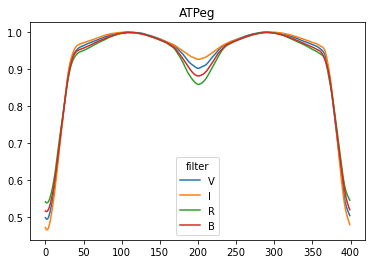

In [24]:
print("Unique names:", obs_det["name"].unique())
observed_curves_plot("ATPeg", obs_det)

## 5. Analysis of observed over-contact data

* Data loading

In [25]:
obs_over = pd.read_csv("observed/observed_over.csv")

* Details about number of records, number of columns and column names

In [26]:
print("Number of records: ", obs_over.shape[0])
print("Number of attributes: ", obs_over.shape[1])
print("Attributes: ", list(obs_over.columns))

Number of records:  43
Number of attributes:  17
Attributes:  ['Unnamed: 0', 'q', 'inc', 'omega1', 'omega2', 'T1', 'T2', 'P', 'Type', 'Spot', 'Ref', 'name', 'filter', 'curve', 't1_t2', 'primary__equivalent_radius', 'secondary__equivalent_radius']


* Details about unique filters and distribution of data for each of them

In [27]:
print("Unique filters:", obs_over["filter"].unique())
print("Distribution of records in each type of filter: \n", obs_over["filter"].value_counts())

Unique filters: ['V' 'B' 'I' 'R']
Distribution of records in each type of filter: 
 V    14
B    11
R    11
I     7
Name: filter, dtype: int64


* Basic statistics about numeric columns

In [28]:
obs_over_copy = obs_over.copy()
obs_over_copy = obs_over_copy.drop(columns=['Unnamed: 0', 'Type', 'Spot', 'Ref', 'name', 'filter', 'curve',])
print("Description of numeric attributes: \n ", obs_over_copy.describe())

Description of numeric attributes: 
                 q        inc     omega1     omega2           T1           T2  \
count  43.000000  43.000000  43.000000  43.000000    43.000000    43.000000   
mean    0.665186  76.091860   2.976698   2.976698  6068.325581  6009.976744   
std     0.872349   9.351258   1.349328   1.349328   664.729867   585.130286   
min     0.169000  54.740000   2.080000   2.080000  4874.000000  4660.000000   
25%     0.250000  70.900000   2.317000   2.317000  5750.000000  5644.000000   
50%     0.290000  78.400000   2.396000   2.396000  6200.000000  6210.000000   
75%     0.502000  83.220000   2.835000   2.835000  6500.000000  6449.000000   
max     2.932000  86.000000   6.397000   6.397000  7000.000000  6750.000000   

               P      t1_t2  primary__equivalent_radius  \
count  43.000000  43.000000                   43.000000   
mean    0.404624   1.009270                    0.475483   
std     0.103691   0.039285                    0.077960   
min     0.2347

* Correlation matrix
    * We selected only *inclination, mass ratio, potentials, temperature ratio* and *radii* to calculate correlation matrix, as those parameters are the most important for us, as we can use them to plot light curves.

In [29]:
corr_df = obs_over_copy[['q', 'inc', 'omega1', 'omega2', 't1_t2', 'primary__equivalent_radius', 'secondary__equivalent_radius']].corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,q,inc,omega1,omega2,t1_t2,primary__equivalent_radius,secondary__equivalent_radius
q,1.000000,0.385687,0.998260,0.998260,0.295695,-0.939324,0.974352
inc,0.385687,1.000000,0.387483,0.387483,-0.099991,-0.372730,0.445476
omega1,0.998260,0.387483,1.000000,1.000000,0.264691,-0.957682,0.981616
omega2,0.998260,0.387483,1.000000,1.000000,0.264691,-0.957682,0.981616
t1_t2,0.295695,-0.099991,0.264691,0.264691,1.000000,-0.102516,0.193947
primary__equivalent_radius,-0.939324,-0.372730,-0.957682,-0.957682,-0.102516,1.000000,-0.968929
secondary__equivalent_radius,0.974352,0.445476,0.981616,0.981616,0.193947,-0.968929,1.000000


* In the next plot we can see all observed detached light curve. To be able to read array of light curve we need to use *literal_eval()* function

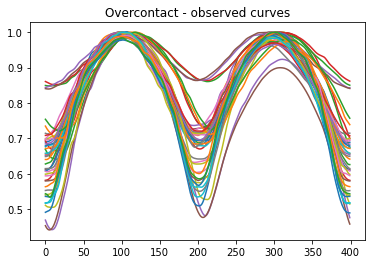

In [30]:
for i in range(len(obs_over)):
    plt.plot(literal_eval(obs_over.curve[i]))
plt.title("Overcontact - observed curves")
plt.show()

* In the next plot we can see light curve of ATPeg binary star plotted for each filter of V, I, R, B using our function *observed_curves_plot()*

Unique names: ['AH Aur' 'AKHer' 'ASCrB' 'BHCas' 'BQAri' 'BXDra' 'GSC 0763-0572' 'HIDra'
 'UVLyn' 'V1128Tau' 'V2612Oph' 'V2790Ori' 'V369Mon' 'YZPho']


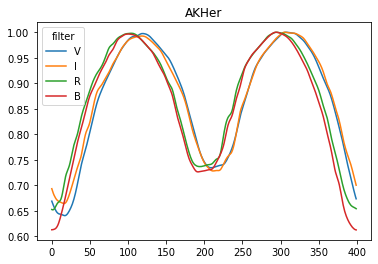

In [32]:
print("Unique names:", obs_over["name"].unique())
observed_curves_plot("AKHer", obs_over)